In [2]:
import numpy as np
import pandas as pd

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

In [5]:
import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('ggplot')

In [6]:
from tqdm import tqdm

## Load the data

In [7]:
dev = pd.read_csv("civility_data/dev.tsv", sep='\t')
mini_demographic_dev = pd.read_csv("civility_data/mini_demographic_dev.tsv", sep='\t')
test = pd.read_csv("civility_data/test.tsv", sep='\t')
train = pd.read_csv("civility_data/train.tsv", sep='\t')

In [8]:
dev['bin_label'] = [0 if l == "OFF" else 1 for l in dev["label"]]

In [9]:
dev.head(5)

text label category  \
0  @USER She should ask a few native Americans wh...   OFF      UNT   
1  @USER @USER Go home you’re drunk!!! @USER #MAG...   OFF      TIN   
2  Amazon is investigating Chinese employees who ...   NOT      NaN   
3  @USER Someone should'veTaken" this piece of sh...   OFF      UNT   
4  @USER @USER Obama wanted liberals &amp; illega...   NOT      NaN   

   perspective_score  bin_label  
0           0.311852          0  
1           0.566334          0  
2           0.110361          1  
3           0.927032          0  
4           0.319764          1

<AxesSubplot:xlabel='label', ylabel='count'>

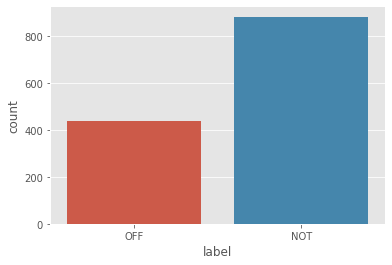

In [10]:
sns.countplot(dev["label"])

In [230]:
len(dev[dev['label'] == 'OFF']), len(dev[dev['label'] == 'NOT']) 

(440, 884)

In [11]:
mini_demographic_dev["bin_label"] = [1 for _ in range(len(mini_demographic_dev))]

In [12]:
mini_demographic_dev.head(5)

text demographic  \
0  People make mistakes. It takes a good person t...       White   
1  Only one on our road with power, but no cable ...       White   
2      I love when baby's yawn I think it's so cute.       White   
3  theres so many hoes now that i actually think ...       White   
4  Today is the day Adalynn Alexis will be here! ...       White   

   perspective_score  bin_label  
0           0.041031          1  
1           0.061435          1  
2           0.056817          1  
3           0.503459          1  
4           0.092183          1

In [13]:
mini_demographic_dev["pred_label"] = [0 if l > 0.8 else 1 for l in mini_demographic_dev["perspective_score"]]

In [14]:
train["bin_label"] = [0 if l == "OFF" else 1 for l in train["label"]]

In [15]:
train.head(5)

text label category  bin_label
0      @USER @USER You are an embarrassing citizen!!   OFF      TIN          0
1  @USER Seems hard to believe that you stood nex...   OFF      TIN          0
2  @USER @USER @USER Wow !!! no wonder the Libera...   OFF      TIN          0
3  @USER @USER And not all idiots grandstands lik...   OFF      TIN          0
4      @USER Bring on the hypocrite gungrabber. MAGA   OFF      TIN          0

## Off-the-shelf Model Exploration

- Use the provided `perspecitve_score` values to classify each tweet in `dev.tsv` and `mini_demographic_dev.tsv` as toxic or non-toxic. As a starting point, assume that a tweet is considered offensive if it contains a toxicity score > 0.8 (you may optionally explore other thresholds).
- Using `dev.tsv` report the Accuracy and F1 Scores of PerspectiveAPI for offensiveness classification.
- Using `mini_demographic_dev.tsv`, separately report the FPR for each demographic group (assuming no tweet in `mini_demographic_dev.tsv` is actually offensive).
- Briefly discuss your results


### Accuracy and F1-scores of PerspectiveAPI for offensive classifaction on `dev.tsv`

Get toxicity prediction

In [16]:
def get_toxicity_prediction(perspective_score):
    return 0 if perspective_score > 0.8 else 1
get_toxicity_prediction(0.801)

0

In [17]:
dev["pred_label"] = dev["perspective_score"].apply(get_toxicity_prediction)

Present statistics

In [18]:
correct = sum(np.where(dev["pred_label"] == dev["bin_label"], 1, 0))
total = len(dev)
accuracy = correct/total
print("Accuracy of PerspectiveAPI is", accuracy)

Accuracy of PerspectiveAPI is 0.7643504531722054


In [19]:
f1_score(y_true=dev["bin_label"], y_pred=dev["pred_label"])

0.8472086190009795

In [20]:
print(classification_report(y_true=dev["bin_label"], y_pred=dev["pred_label"]))

              precision    recall  f1-score   support

           0       0.89      0.33      0.49       440
           1       0.75      0.98      0.85       884

    accuracy                           0.76      1324
   macro avg       0.82      0.66      0.67      1324
weighted avg       0.79      0.76      0.73      1324



### Report the FPR for each demographic group using `mini_demographic_dev.tsv`
Assume no tweet in `mini_demographic_dev.tsv` is actually offensive.

In [21]:
mini_demographic_dev.head(5)

text demographic  \
0  People make mistakes. It takes a good person t...       White   
1  Only one on our road with power, but no cable ...       White   
2      I love when baby's yawn I think it's so cute.       White   
3  theres so many hoes now that i actually think ...       White   
4  Today is the day Adalynn Alexis will be here! ...       White   

   perspective_score  bin_label  pred_label  
0           0.041031          1           1  
1           0.061435          1           1  
2           0.056817          1           1  
3           0.503459          1           1  
4           0.092183          1           1

In [22]:
unique_demographics = mini_demographic_dev["demographic"].unique()
unique_demographics

array(['White', 'Hispanic', 'AA', 'Other'], dtype=object)

<AxesSubplot:xlabel='demographic', ylabel='count'>

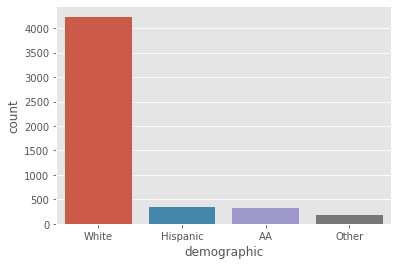

In [23]:
sns.countplot(mini_demographic_dev["demographic"])

In [24]:
white_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "White"]
hispanic_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "Hispanic"]
AA_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "AA"]
other_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "Other"]

In [25]:
def get_measure(y_actual, y_pred):
    CM = confusion_matrix(1-y_actual, 1-y_pred, labels=[0, 1])

    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]

    return (TP, FP, TN, FN)

def get_fpr(df):
    TP, FP, TN, FN = get_measure(df["bin_label"].values, df["pred_label"].values)
    return FP/(FP+TN)

def get_fpr_(y_actual, y_pred):
    TP, FP, TN, FN = get_measure(y_actual, y_pred)
    return FP/(FP+TN)

White FPR: 0.07319952774498228
Hispanic FPR: 0.10149253731343283
AA FPR: 0.1897590361445783
Other FPR: 0.011764705882352941


Text(0.5, 1.0, 'False Positive Rate (FPR) of Toxicity Detection')

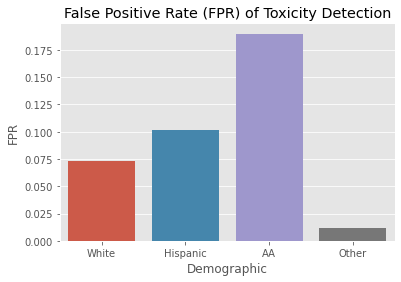

In [26]:
# FPR = FP/(FP+TN)
white_fpr = get_fpr(white_df)
hispanic_fpr = get_fpr(hispanic_df)
AA_fpr = get_fpr(AA_df)
other_fpr = get_fpr(other_df)

print("White FPR:", white_fpr)
print("Hispanic FPR:", hispanic_fpr)
print("AA FPR:", AA_fpr)
print("Other FPR:", other_fpr)

ax = sns.barplot(['White', 'Hispanic', 'AA', 'Other'], [white_fpr, hispanic_fpr, AA_fpr, other_fpr])
ax.set_ylabel("FPR")
ax.set_xlabel("Demographic")
ax.set_title("False Positive Rate (FPR) of Toxicity Detection")

## Custom Model Exploration

- Build your own classifier to distinguish offensive (`OFF`) tweets from non-offensive (`NOT`) tweets. Your model should be trained on `train.tsv` and should obtain an accuracy of at least 70% and an F1 score of at least 80% over `dev.tsv` (this should be easy to obtain with surface-level features).
- Report the accuracy and F1 score of your model over `dev.tsv`
- Report FPR over `mini_demographic_dev.tsv`
- Briefly discuss your results. How does your model compare to PerspectiveAPI?

In [27]:
#NLP tools
import re
import nltk
# nltk.download('stopwords')
# nltk.download('rslp')
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

In [31]:
# X_train = train["text"].values
# y_train = np.array([0.0 if l=="OFF" else 1.0 for l in train["label"]])
# X_test = dev["text"].values
# y_test = np.array([0.0 if l=="OFF" else 1.0 for l in dev["label"]])

# # Clean text
# def preprocessing(data):
#     all_stopwords = stopwords.words('english')
#     all_stopwords.remove('not')
#     corpus = []
#     for tweet in data:
#         review = re.sub(r"@[A-Za-z0-9_]+", " ", tweet)
#         review = re.sub('RT', ' ', review)
#         review = re.sub(r"https?://[A-Za-z0-9./]+", " ", review)
#         review = re.sub(r"https?", " ", review)
#         review = re.sub(r"\\[A-Za-z0-9./]+"," ", review)
#         review = re.sub('[^a-zA-Z]', ' ', review)
#         review = review.lower()
#         review = review.split()
#         review = [word for word in review if not word in set(all_stopwords) if len(word) > 2]
#         review = ' '.join(review)
#         corpus.append(review)

#     return np.array(corpus)

# X_train = preprocessing(X_train)
# X_test = preprocessing(X_test)

# Clean text

from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

# sentences = [
#     "CANT WAIT for the new season of #TwinPeaks ＼(^o^)／!!! #davidlynch #tvseries :)))",
#     "I saw the new #johndoe movie and it suuuuucks!!! WAISTED $10... #badmovies :/",
#     "@SentimentSymp:  can't wait for the Nov 9 #Sentiment talks!  YAAAAAAY !!! :-D http://sentimentsymposium.com/."
# ]

# for s in sentences:
#     print(" ".join(text_processor.pre_process_doc(s)))

text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
        'time', 'url', 'date', 'number'],
    # terms that will be annotated
#     annotate={"hashtag", "allcaps", "elongated", "repeated",
#         'emphasis', 'censored'},
    fix_html=True,  # fix HTML tokens

    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    segmenter="twitter", 

    # corpus from which the word statistics are going to be used 
    # for spell correction
    corrector="twitter", 

    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=True,  # spell correction for elongated words

    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,

    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons]
)
    
def preprocessing(data):

    all_stopwords = stopwords.words('english')
    all_stopwords.remove('not')
    corpus = []
    for tweet in tqdm(data):
        review = tweet
        review = re.sub(r"\\[A-Za-z0-9./]+"," ", review)
        review = " ".join(text_processor.pre_process_doc(review))
        review = re.sub(r"@[A-Za-z0-9_]+", " ", review)
        review = re.sub('RT', ' ', review)
        review = re.sub(r"https?://[A-Za-z0-9./]+", " ", review)
        review = re.sub(r"https?", " ", review)
        review = re.sub('[^a-zA-Z]', ' ', review)
        review = re.sub('user', ' ', review)
        review = review.lower()
        review = review.split()
        review = [word for word in review if not word in set(all_stopwords) if len(word) > 2]
        review = ' '.join(review)
        corpus.append(review)

    return np.array(corpus)


dev = pd.read_csv("civility_data/dev.tsv", sep='\t')
mini_demographic_dev = pd.read_csv("civility_data/mini_demographic_dev.tsv", sep='\t')
test = pd.read_csv("civility_data/test.tsv", sep='\t')
train = pd.read_csv("civility_data/train.tsv", sep='\t')
mini_demographic_dev["bin_label"] = [1 for _ in range(len(mini_demographic_dev))]

print("Preprocessing tweets...")
train['text'] = preprocessing(train.text.values)
train['len'] = [len(x.split(' ')) for x in train.text.values]
train = train[train['len'] > 2]

dev['text'] = preprocessing(dev.text.values)
mini_demographic_dev["text"] = preprocessing(mini_demographic_dev.text.values)

X_train = train["text"].values
y_train = np.array([0.0 if l=="OFF" else 1.0 for l in train["label"]])
X_test = dev["text"].values
y_test = np.array([0.0 if l=="OFF" else 1.0 for l in dev["label"]])
X_test_dev = mini_demographic_dev["text"].values
y_test_dev = mini_demographic_dev["bin_label"].values


# print("Preprocessing tweets...")
# X_train = preprocessing(X_train)
# X_test = preprocessing(X_test)
# X_test_dev = preprocessing(X_test_dev)


# max_features = 16097
# maxlen = 100
# embedding_dim = 100

# tokenizer = text.Tokenizer(num_words=max_features)
# tokenizer.fit_on_texts(list(X_train))
# X_train = tokenizer.texts_to_sequences(X_train)
# X_test = tokenizer.texts_to_sequences(X_test)
# X_test_dev = tokenizer.texts_to_sequences(X_test_dev)
# X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
# X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
# X_test_dev = sequence.pad_sequences(X_test_dev, maxlen=maxlen)


# embeddings_index = dict()

# GLOVE_PATH = 'glove.twitter.27B.100d.txt'
# print("Processing GloVe word embeddings...")
# with open(GLOVE_PATH, 'r') as glove_file:
#     for line in glove_file:
#         values = line.split()
#         word = values[0]
#         coefs = np.asarray(values[1:], dtype='float32')
#         embeddings_index[word] = coefs

# print("Found", len(embeddings_index), "word vectors!")

# embedding_matrix = np.zeros((max_features, embedding_dim))
# print("Creating embedding matrix...")
# for i in tqdm(range(len(tokenizer.word_index.items()))):
#     word, index = list(tokenizer.word_index.items())[i]
#     if index > max_features-1:
#         break
#     else:
#         embedding_vector = embeddings_index.get(word)
#         if embedding_vector is not None:
#             embedding_matrix[index] = embedding_vector

# with open('embedding_matrix_100.npy', 'wb') as f:
#     np.save(f, embedding_matrix)

# with open('embedding_matrix.npy', 'rb') as f:
#     embedding_matrix = np.load(f)

# with open('embedding_matrix_fasttext.npy', 'rb') as f:
#     embedding_matrix = np.load(f)

Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...


  1%|▏         | 147/10592 [00:00<00:07, 1469.56it/s]

Preprocessing tweets...


100%|██████████| 5072/5072 [00:02<00:00, 1886.50it/s]


In [33]:
preprocessing(['Not the best day #HateLife \\ud83d\\ude15'])

100%|██████████| 1/1 [00:00<00:00, 2242.94it/s]


array(['not best day hate life'], dtype='<U22')

In [35]:
print(X_train[1])

wow wonder liberals got worse party bullies women accountability


In [36]:
X_test_dev = preprocessing(mini_demographic_dev["text"].values)
y_test_dev = mini_demographic_dev["bin_label"].values

100%|██████████| 5072/5072 [00:00<00:00, 7219.03it/s]


In [37]:
X_test_dev

array(['people make mistakes takes good person learn learning',
       'one road power cable internet guess not',
       'love baby yawn think cute', ..., 'straight relaxin right',
       'una bala mas aire', 'gotta get doctor today running low medicine'],
      dtype='<U144')

In [120]:
bad_words = ["4r5e", "5h1t", "5hit", "a55", "anal", "anus", "ar5e", "arrse", "arse", "ass", "ass-fucker", "asses", "assfucker", "assfukka", "asshole", "assholes", "asswhole", "a_s_s", "b!tch", "b00bs", "b17ch", "b1tch", "ballbag", "balls", "ballsack", "bastard", "beastial", "beastiality", "bellend", "bestial", "bestiality", "bi+ch", "biatch", "bitch", "bitcher", "bitchers", "bitches", "bitchin", "bitching", "bloody", "blow job", "blowjob", "blowjobs", "boiolas", "bollock", "bollok", "boner", "boob", "boobs", "booobs", "boooobs", "booooobs", "booooooobs", "breasts", "buceta", "bugger", "bum", "bunny fucker", "butt", "butthole", "buttmuch", "buttplug", "c0ck", "c0cksucker", "carpet muncher", "cawk", "chink", "cipa", "cl1t", "clit", "clitoris", "clits", "cnut", "cock", "cock-sucker", "cockface", "cockhead", "cockmunch", "cockmuncher", "cocks", "cocksuck", "cocksucked", "cocksucker", "cocksucking", "cocksucks", "cocksuka", "cocksukka", "cok", "cokmuncher", "coksucka", "coon", "cox", "crap", "cum", "cummer", "cumming", "cums", "cumshot", "cunilingus", "cunillingus", "cunnilingus", "cunt", "cuntlick", "cuntlicker", "cuntlicking", "cunts", "cyalis", "cyberfuc", "cyberfuck", "cyberfucked", "cyberfucker", "cyberfuckers", "cyberfucking", "d1ck", "damn", "dick", "dickhead", "dildo", "dildos", "dink", "dinks", "dirsa", "dlck", "dog-fucker", "doggin", "dogging", "donkeyribber", "doosh", "duche", "dyke", "ejaculate", "ejaculated", "ejaculates", "ejaculating", "ejaculatings", "ejaculation", "ejakulate", "f u c k", "f u c k e r", "f4nny", "fag", "fagging", "faggitt", "faggot", "faggs", "fagot", "fagots", "fags", "fanny", "fannyflaps", "fannyfucker", "fanyy", "fatass", "fcuk", "fcuker", "fcuking", "feck", "fecker", "felching", "fellate", "fellatio", "fingerfuck", "fingerfucked", "fingerfucker", "fingerfuckers", "fingerfucking", "fingerfucks", "fistfuck", "fistfucked", "fistfucker", "fistfuckers", "fistfucking", "fistfuckings", "fistfucks", "flange", "fook", "fooker", "fuck", "fucka", "fucked", "fucker", "fuckers", "fuckhead", "fuckheads", "fuckin", "fucking", "fuckings", "fuckingshitmotherfucker", "fuckme", "fucks", "fuckwhit", "fuckwit", "fudge packer", "fudgepacker", "fuk", "fuker", "fukker", "fukkin", "fuks", "fukwhit", "fukwit", "fux", "fux0r", "f_u_c_k", "gangbang", "gangbanged", "gangbangs", "gaylord", "gaysex", "goatse", "God", "god-dam", "god-damned", "goddamn", "goddamned", "hardcoresex", "hell", "heshe", "hoar", "hoare", "hoer", "homo", "hore", "horniest", "horny", "hotsex", "jack-off", "jackoff", "jap", "jerk-off", "jism", "jiz", "jizm", "jizz", "kawk", "knob", "knobead", "knobed", "knobend", "knobhead", "knobjocky", "knobjokey", "kock", "kondum", "kondums", "kum", "kummer", "kumming", "kums", "kunilingus", "l3i+ch", "l3itch", "labia", "lust", "lusting", "m0f0", "m0fo", "m45terbate", "ma5terb8", "ma5terbate", "masochist", "master-bate", "masterb8", "masterbat*", "masterbat3", "masterbate", "masterbation", "masterbations", "masturbate", "mo-fo", "mof0", "mofo", "mothafuck", "mothafucka", "mothafuckas", "mothafuckaz", "mothafucked", "mothafucker", "mothafuckers", "mothafuckin", "mothafucking", "mothafuckings", "mothafucks", "mother fucker", "motherfuck", "motherfucked", "motherfucker", "motherfuckers", "motherfuckin", "motherfucking", "motherfuckings", "motherfuckka", "motherfucks", "muff", "mutha", "muthafecker", "muthafuckker", "muther", "mutherfucker", "n1gga", "n1gger", "nazi", "nigg3r", "nigg4h", "nigga", "niggah", "niggas", "niggaz", "nigger", "niggers", "nob", "nob jokey", "nobhead", "nobjocky", "nobjokey", "numbnuts", "nutsack", "orgasim", "orgasims", "orgasm", "orgasms", "p0rn", "pawn", "pecker", "penis", "penisfucker", "phonesex", "phuck", "phuk", "phuked", "phuking", "phukked", "phukking", "phuks", "phuq", "pigfucker", "pimpis", "piss", "pissed", "pisser", "pissers", "pisses", "pissflaps", "pissin", "pissing", "pissoff", "poop", "porn", "porno", "pornography", "pornos", "prick", "pricks", "pron", "pube", "pusse", "pussi", "pussies", "pussy", "pussys", "rectum", "retard", "rimjaw", "rimming", "s hit", "s.o.b.", "sadist", "schlong", "screwing", "scroat", "scrote", "scrotum", "semen", "sex", "sh!+", "sh!t", "sh1t", "shag", "shagger", "shaggin", "shagging", "shemale", "shi+", "shit", "shitdick", "shite", "shited", "shitey", "shitfuck", "shitfull", "shithead", "shiting", "shitings", "shits", "shitted", "shitter", "shitters", "shitting", "shittings", "shitty", "skank", "slut", "sluts", "smegma", "smut", "snatch", "son-of-a-bitch", "spac", "spunk", "s_h_i_t", "t1tt1e5", "t1tties", "teets", "teez", "testical", "testicle", "tit", "titfuck", "tits", "titt", "tittie5", "tittiefucker", "titties", "tittyfuck", "tittywank", "titwank", "tosser", "turd", "tw4t", "twat", "twathead", "twatty", "twunt", "twunter", "v14gra", "v1gra", "vagina", "viagra", "vulva", "w00se", "wang", "wank", "wanker", "wanky", "whoar", "whore", "willies", "willy", "xrated", "xxx"]

In [143]:
X_train_clean = []

for sent in X_train:
    cur_sent = []
    for word in sent.split(' '):
        if word not in bad_words:
            cur_sent.append(word)
            
    X_train_clean.append(' '.join(cur_sent[:-1]))

In [129]:
X_train_clean

['seems hard believe stood next guy wearing shorts not take',
 'wow wonder liberals got worse party bullies women',
 'not idiots grandstands',
 'bring hypocrite gungrabber',
 'thing agree match point following rules think honestly call thief penalized',
 'second',
 'eric holder major embarrassment law enforcement nothing innocent black males killed streets one sorry black',
 'average american money lying around buy new glock likely antifa using unemployment check purchase dental work',
 'liberals realize thousands unaccompanied minors thrown across border supposed take care angelina',
 'fascists nazis not abide patriotic views shared presence glad brownshirt arm antifa left inflict usual violence citizens dare speak hear dems enjoy wings beer country music less walk',
 '',
 'told stop eating booty day',
 'given number',
 'breaking circuit order delete tweet makes trump look like',
 'know not facetious incapable understanding',
 'peach naturally human toadette created drug become human 

In [144]:
X_train_unique = []

for sent in X_train:
    cur_sent = []
    for word in sent.split(' '):
        if word not in cur_sent:
            cur_sent.append(word)
            
    X_train_unique.append(' '.join(cur_sent[:-1]))

In [145]:
X_train_unique

['seems hard believe stood next guy wearing shorts not masturbate take',
 'wow wonder liberals got worse party bullies women',
 'not idiots grandstands',
 'bring hypocrite gungrabber',
 'thing agree match point following rules think sex honestly call thief penalized shit',
 'second fucking',
 'eric holder major embarrassment law enforcement nothing innocent black males killed streets one sorry',
 'average american money lying around buy new glock likely antifa using unemployment check purchase dental work',
 'liberals realize thousands unaccompanied minors thrown across border supposed take care angelina',
 'fascists nazis not abide patriotic views shared presence glad brownshirt arm antifa left inflict usual violence citizens dare speak hear dems enjoy wings beer country music less walk',
 'bitch fucking felt',
 'told stop eating booty day',
 'given number',
 'breaking circuit order delete tweet makes trump look like',
 'know not facetious incapable understanding',
 'peach naturally h

### Comparison of basic models

In [73]:
# !pip3 install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 3.7 MB/s eta 0:00:003.8 MB/s eta 0:00:01


In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost.sklearn import XGBClassifier

# todo: SGDClassifier, SVC, GaussianNB, GradientBoostingClassifier, LGBMClassifier, XGBClassifier

In [130]:
def model_eval(model, model_name="", X_train=X_train):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
    print("F1 Score: {:.6f}".format(f1_score(y_test, y_pred)))
    print(classification_report(y_test, y_pred))
    dev["our_pred"] = [int(i) for i in y_pred]

    cm = confusion_matrix(y_test, y_pred)
    fig = sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.savefig(model_name + "_cm.png")
    plt.close()
    
    # Test on demographic
    y_pred_dev = model.predict(X_test_dev)
    
    print("Accuracy dem: {:.2f}%".format(accuracy_score(y_test_dev, y_pred_dev) * 100))
    print("F1 Score dem: {:.6f}".format(f1_score(y_test_dev, y_pred_dev)))

    mini_demographic_dev["pred_label"] = [int(i) for i in y_pred_dev]

    white_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "White"]
    hispanic_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "Hispanic"]
    AA_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "AA"]
    other_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "Other"]

    white_fpr = get_fpr(white_df)
    hispanic_fpr = get_fpr(hispanic_df)
    AA_fpr = get_fpr(AA_df)
    other_fpr = get_fpr(other_df)
    
    print("")
    print("White FPR:", white_fpr)
    print("Hispanic FPR:", hispanic_fpr)
    print("AA FPR:", AA_fpr)
    print("Other FPR:", other_fpr)

    ax = sns.barplot(['White', 'Hispanic', 'AA', 'Other'], [white_fpr, hispanic_fpr, AA_fpr, other_fpr])
    ax.set_ylabel("FPR")
    ax.set_xlabel("Demographic")
    ax.set_title("False Positive Rate (FPR) of Toxicity Detection")

**SGDClassifier**

Accuracy: 72.36%
F1 Score: 0.825880
              precision    recall  f1-score   support

         0.0       0.85      0.20      0.33       440
         1.0       0.71      0.98      0.83       884

    accuracy                           0.72      1324
   macro avg       0.78      0.59      0.58      1324
weighted avg       0.76      0.72      0.66      1324

Accuracy dem: 93.79%
F1 Score dem: 0.967952

White FPR: 0.05619834710743802
Hispanic FPR: 0.07462686567164178
AA FPR: 0.1566265060240964
Other FPR: 0.0


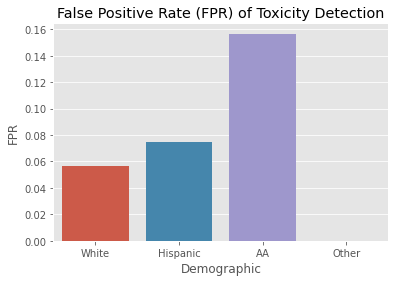

In [153]:
# todo: SGDClassifier, SVC, GaussianNB, GradientBoostingClassifier, LGBMClassifier, XGBClassifier

sgd = Pipeline([
    ('vectorizer', CountVectorizer()),   
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                           alpha=0.0005, random_state=0,
                           max_iter=50, tol=None))
])

model_eval(sgd, "SGDClassifier")

**CatBoostClassifier**

Learning rate set to 0.026702
0:	learn: 0.6890390	total: 159ms	remaining: 2m 38s
1:	learn: 0.6850358	total: 194ms	remaining: 1m 36s
2:	learn: 0.6810534	total: 224ms	remaining: 1m 14s
3:	learn: 0.6778585	total: 258ms	remaining: 1m 4s
4:	learn: 0.6740472	total: 292ms	remaining: 58.2s
5:	learn: 0.6708187	total: 331ms	remaining: 54.9s
6:	learn: 0.6673696	total: 373ms	remaining: 53s
7:	learn: 0.6642177	total: 410ms	remaining: 50.8s
8:	learn: 0.6610471	total: 451ms	remaining: 49.7s
9:	learn: 0.6585961	total: 488ms	remaining: 48.3s
10:	learn: 0.6555547	total: 530ms	remaining: 47.7s
11:	learn: 0.6525075	total: 573ms	remaining: 47.2s
12:	learn: 0.6499481	total: 612ms	remaining: 46.5s
13:	learn: 0.6475108	total: 651ms	remaining: 45.9s
14:	learn: 0.6454350	total: 683ms	remaining: 44.8s
15:	learn: 0.6434370	total: 714ms	remaining: 43.9s
16:	learn: 0.6410934	total: 750ms	remaining: 43.4s
17:	learn: 0.6390218	total: 783ms	remaining: 42.7s
18:	learn: 0.6372047	total: 824ms	remaining: 42.6s
19:	learn:

163:	learn: 0.5640040	total: 7.14s	remaining: 36.4s
164:	learn: 0.5636968	total: 7.19s	remaining: 36.4s
165:	learn: 0.5635105	total: 7.23s	remaining: 36.3s
166:	learn: 0.5633317	total: 7.28s	remaining: 36.3s
167:	learn: 0.5631287	total: 7.33s	remaining: 36.3s
168:	learn: 0.5629645	total: 7.38s	remaining: 36.3s
169:	learn: 0.5627711	total: 7.42s	remaining: 36.2s
170:	learn: 0.5626250	total: 7.46s	remaining: 36.2s
171:	learn: 0.5624497	total: 7.5s	remaining: 36.1s
172:	learn: 0.5622115	total: 7.54s	remaining: 36.1s
173:	learn: 0.5620577	total: 7.65s	remaining: 36.3s
174:	learn: 0.5619267	total: 7.69s	remaining: 36.3s
175:	learn: 0.5616723	total: 7.74s	remaining: 36.2s
176:	learn: 0.5614936	total: 7.79s	remaining: 36.2s
177:	learn: 0.5613517	total: 7.86s	remaining: 36.3s
178:	learn: 0.5610837	total: 7.91s	remaining: 36.3s
179:	learn: 0.5608772	total: 7.96s	remaining: 36.3s
180:	learn: 0.5606809	total: 8.01s	remaining: 36.2s
181:	learn: 0.5605229	total: 8.04s	remaining: 36.2s
182:	learn: 0

323:	learn: 0.5373445	total: 14s	remaining: 29.2s
324:	learn: 0.5372004	total: 14.1s	remaining: 29.2s
325:	learn: 0.5370976	total: 14.1s	remaining: 29.1s
326:	learn: 0.5369309	total: 14.1s	remaining: 29.1s
327:	learn: 0.5366688	total: 14.2s	remaining: 29s
328:	learn: 0.5365311	total: 14.2s	remaining: 29s
329:	learn: 0.5363769	total: 14.2s	remaining: 28.9s
330:	learn: 0.5362023	total: 14.3s	remaining: 28.9s
331:	learn: 0.5360717	total: 14.3s	remaining: 28.8s
332:	learn: 0.5359250	total: 14.3s	remaining: 28.7s
333:	learn: 0.5357403	total: 14.4s	remaining: 28.7s
334:	learn: 0.5355259	total: 14.4s	remaining: 28.6s
335:	learn: 0.5353420	total: 14.5s	remaining: 28.6s
336:	learn: 0.5351491	total: 14.5s	remaining: 28.5s
337:	learn: 0.5349604	total: 14.5s	remaining: 28.5s
338:	learn: 0.5347609	total: 14.6s	remaining: 28.4s
339:	learn: 0.5346039	total: 14.6s	remaining: 28.3s
340:	learn: 0.5344620	total: 14.6s	remaining: 28.3s
341:	learn: 0.5343006	total: 14.7s	remaining: 28.2s
342:	learn: 0.5341

482:	learn: 0.5117199	total: 20s	remaining: 21.4s
483:	learn: 0.5115958	total: 20s	remaining: 21.3s
484:	learn: 0.5113963	total: 20s	remaining: 21.3s
485:	learn: 0.5112986	total: 20.1s	remaining: 21.2s
486:	learn: 0.5111369	total: 20.1s	remaining: 21.2s
487:	learn: 0.5110159	total: 20.1s	remaining: 21.1s
488:	learn: 0.5108425	total: 20.2s	remaining: 21.1s
489:	learn: 0.5107489	total: 20.2s	remaining: 21.1s
490:	learn: 0.5106364	total: 20.3s	remaining: 21s
491:	learn: 0.5105285	total: 20.3s	remaining: 21s
492:	learn: 0.5103752	total: 20.3s	remaining: 20.9s
493:	learn: 0.5102942	total: 20.4s	remaining: 20.9s
494:	learn: 0.5101394	total: 20.4s	remaining: 20.8s
495:	learn: 0.5099484	total: 20.5s	remaining: 20.8s
496:	learn: 0.5098176	total: 20.5s	remaining: 20.7s
497:	learn: 0.5097149	total: 20.5s	remaining: 20.7s
498:	learn: 0.5095123	total: 20.6s	remaining: 20.6s
499:	learn: 0.5093566	total: 20.6s	remaining: 20.6s
500:	learn: 0.5092032	total: 20.6s	remaining: 20.6s
501:	learn: 0.5090190	

642:	learn: 0.4909857	total: 28.1s	remaining: 15.6s
643:	learn: 0.4908867	total: 28.1s	remaining: 15.5s
644:	learn: 0.4907952	total: 28.1s	remaining: 15.5s
645:	learn: 0.4907103	total: 28.2s	remaining: 15.4s
646:	learn: 0.4906440	total: 28.2s	remaining: 15.4s
647:	learn: 0.4905318	total: 28.2s	remaining: 15.3s
648:	learn: 0.4904416	total: 28.3s	remaining: 15.3s
649:	learn: 0.4902958	total: 28.3s	remaining: 15.3s
650:	learn: 0.4902100	total: 28.4s	remaining: 15.2s
651:	learn: 0.4901282	total: 28.4s	remaining: 15.2s
652:	learn: 0.4900088	total: 28.4s	remaining: 15.1s
653:	learn: 0.4898432	total: 28.5s	remaining: 15.1s
654:	learn: 0.4897406	total: 28.5s	remaining: 15s
655:	learn: 0.4896466	total: 28.6s	remaining: 15s
656:	learn: 0.4895182	total: 28.7s	remaining: 15s
657:	learn: 0.4893401	total: 28.7s	remaining: 14.9s
658:	learn: 0.4892636	total: 28.7s	remaining: 14.9s
659:	learn: 0.4891771	total: 28.8s	remaining: 14.8s
660:	learn: 0.4890392	total: 28.8s	remaining: 14.8s
661:	learn: 0.4888

801:	learn: 0.4732348	total: 34.8s	remaining: 8.59s
802:	learn: 0.4730974	total: 34.8s	remaining: 8.55s
803:	learn: 0.4729445	total: 34.9s	remaining: 8.5s
804:	learn: 0.4728407	total: 34.9s	remaining: 8.46s
805:	learn: 0.4727205	total: 35s	remaining: 8.42s
806:	learn: 0.4726409	total: 35s	remaining: 8.37s
807:	learn: 0.4725559	total: 35.1s	remaining: 8.33s
808:	learn: 0.4724151	total: 35.1s	remaining: 8.29s
809:	learn: 0.4723443	total: 35.2s	remaining: 8.25s
810:	learn: 0.4722653	total: 35.3s	remaining: 8.22s
811:	learn: 0.4721546	total: 35.3s	remaining: 8.17s
812:	learn: 0.4720644	total: 35.3s	remaining: 8.13s
813:	learn: 0.4718902	total: 35.4s	remaining: 8.09s
814:	learn: 0.4718096	total: 35.4s	remaining: 8.04s
815:	learn: 0.4716989	total: 35.5s	remaining: 8s
816:	learn: 0.4715664	total: 35.5s	remaining: 7.96s
817:	learn: 0.4715087	total: 35.6s	remaining: 7.91s
818:	learn: 0.4714407	total: 35.6s	remaining: 7.87s
819:	learn: 0.4713752	total: 35.6s	remaining: 7.82s
820:	learn: 0.471237

960:	learn: 0.4581601	total: 41.7s	remaining: 1.69s
961:	learn: 0.4580521	total: 41.7s	remaining: 1.65s
962:	learn: 0.4580083	total: 41.8s	remaining: 1.61s
963:	learn: 0.4579587	total: 41.9s	remaining: 1.56s
964:	learn: 0.4578574	total: 41.9s	remaining: 1.52s
965:	learn: 0.4577457	total: 42s	remaining: 1.48s
966:	learn: 0.4576618	total: 42.1s	remaining: 1.44s
967:	learn: 0.4575696	total: 42.1s	remaining: 1.39s
968:	learn: 0.4574359	total: 42.2s	remaining: 1.35s
969:	learn: 0.4573592	total: 42.2s	remaining: 1.31s
970:	learn: 0.4572769	total: 42.3s	remaining: 1.26s
971:	learn: 0.4571441	total: 42.3s	remaining: 1.22s
972:	learn: 0.4570934	total: 42.4s	remaining: 1.18s
973:	learn: 0.4569520	total: 42.4s	remaining: 1.13s
974:	learn: 0.4568536	total: 42.5s	remaining: 1.09s
975:	learn: 0.4567633	total: 42.5s	remaining: 1.04s
976:	learn: 0.4566580	total: 42.6s	remaining: 1s
977:	learn: 0.4565524	total: 42.6s	remaining: 959ms
978:	learn: 0.4565038	total: 42.7s	remaining: 915ms
979:	learn: 0.456

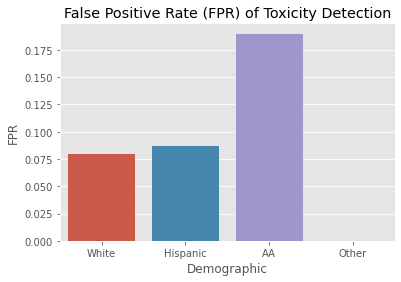

In [164]:
from catboost import CatBoostClassifier

cbc = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
#     ('svd', TruncatedSVD(algorithm='randomized', n_components=300)),
    ('cbc', CatBoostClassifier(n_estimators=1000, early_stopping_rounds=10))
])

model_eval(cbc, "CatBoostClassifier")

**AdaBoostClassifier**

Accuracy: 72.51%
F1 Score: 0.826170
              precision    recall  f1-score   support

         0.0       0.83      0.22      0.34       440
         1.0       0.71      0.98      0.83       884

    accuracy                           0.73      1324
   macro avg       0.77      0.60      0.58      1324
weighted avg       0.75      0.73      0.67      1324

Accuracy dem: 94.42%
F1 Score dem: 0.971301

White FPR: 0.050059031877213694
Hispanic FPR: 0.07462686567164178
AA FPR: 0.13855421686746988
Other FPR: 0.0


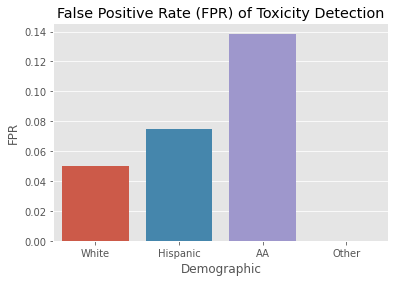

In [173]:
from sklearn.ensemble import AdaBoostClassifier

ada = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
#     ('svd', TruncatedSVD(algorithm='randomized', n_components=300)),
    ('ada', AdaBoostClassifier(n_estimators=10))
])

model_eval(ada, "AdaBoostClassifier")

**ExtraTreesClassifier**

Accuracy: 76.96%
F1 Score: 0.840398
              precision    recall  f1-score   support

         0.0       0.73      0.49      0.59       440
         1.0       0.78      0.91      0.84       884

    accuracy                           0.77      1324
   macro avg       0.75      0.70      0.71      1324
weighted avg       0.76      0.77      0.76      1324

Accuracy dem: 87.40%
F1 Score dem: 0.932772

White FPR: 0.12113341204250296
Hispanic FPR: 0.13134328358208955
AA FPR: 0.24397590361445784
Other FPR: 0.0058823529411764705


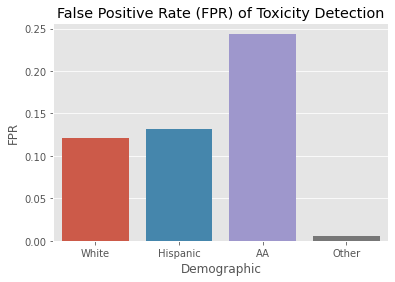

In [167]:
from sklearn.ensemble import ExtraTreesClassifier

ext = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
#     ('svd', TruncatedSVD(algorithm='randomized', n_components=300)),
    ('ext', ExtraTreesClassifier(n_estimators=1000))
])

model_eval(ext, "ExtraTreesClassifier")

**GradientBoostingClassifier**

Accuracy: 74.02%
F1 Score: 0.833010
              precision    recall  f1-score   support

         0.0       0.82      0.28      0.41       440
         1.0       0.73      0.97      0.83       884

    accuracy                           0.74      1324
   macro avg       0.78      0.62      0.62      1324
weighted avg       0.76      0.74      0.69      1324

Accuracy dem: 93.06%
F1 Score dem: 0.964052

White FPR: 0.06422668240850059
Hispanic FPR: 0.07462686567164178
AA FPR: 0.16566265060240964
Other FPR: 0.0


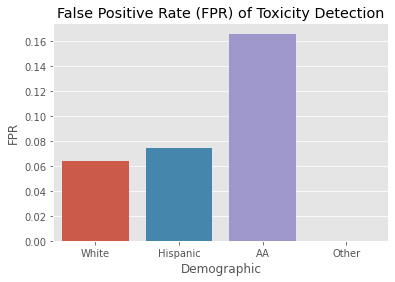

In [154]:
gbc = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
#     ('svd', TruncatedSVD(algorithm='randomized', n_components=300)),
    ('gbc', GradientBoostingClassifier())
])

model_eval(gbc, "GradientBoostingClassifier")

**SVC**

Accuracy: 74.85%
F1 Score: 0.835230
              precision    recall  f1-score   support

         0.0       0.79      0.33      0.47       440
         1.0       0.74      0.95      0.84       884

    accuracy                           0.75      1324
   macro avg       0.76      0.64      0.65      1324
weighted avg       0.76      0.75      0.71      1324

Accuracy dem: 90.30%
F1 Score dem: 0.949026

White FPR: 0.09067296340023613
Hispanic FPR: 0.11044776119402985
AA FPR: 0.21385542168674698
Other FPR: 0.0


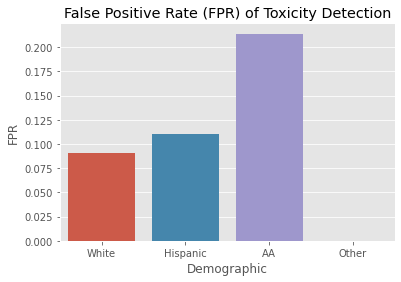

In [155]:
svc = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('svc', SVC()),
])

model_eval(svc, "SVC")

**LGBMClassifier**

Accuracy: 75.08%
F1 Score: 0.831288
              precision    recall  f1-score   support

         0.0       0.72      0.41      0.52       440
         1.0       0.76      0.92      0.83       884

    accuracy                           0.75      1324
   macro avg       0.74      0.67      0.68      1324
weighted avg       0.75      0.75      0.73      1324

Accuracy dem: 89.91%
F1 Score dem: 0.946844

White FPR: 0.09681227863046045
Hispanic FPR: 0.09850746268656717
AA FPR: 0.20783132530120482
Other FPR: 0.0


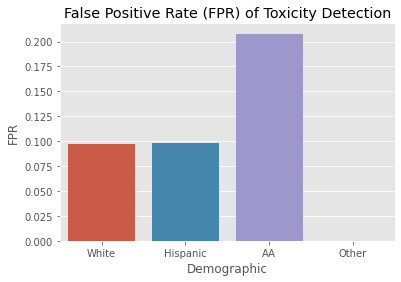

In [156]:
lgbm = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
#     ('svd', TruncatedSVD(algorithm='randomized', n_components=300)),
    ('LGBMClassifier', LGBMClassifier()),
])

model_eval(lgbm, "LGBMClassifier")

**XGBoost Classifier**

[21:31:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 75.38%
F1 Score: 0.835685
              precision    recall  f1-score   support

         0.0       0.75      0.38      0.51       440
         1.0       0.75      0.94      0.84       884

    accuracy                           0.75      1324
   macro avg       0.75      0.66      0.67      1324
weighted avg       0.75      0.75      0.73      1324

Accuracy dem: 91.11%
F1 Score dem: 0.953472

White FPR: 0.08547815820543093
Hispanic FPR: 0.09253731343283582
AA FPR: 0.1746987951807229
Other FPR: 0.0


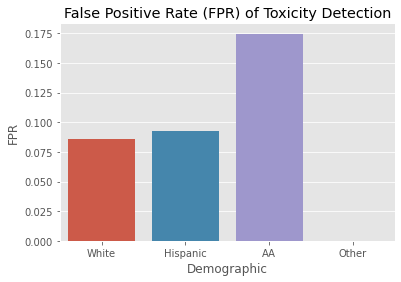

In [157]:
xgb = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
#      ('svd', TruncatedSVD(algorithm='randomized', n_components=300)),
    ('XGBClassifier', XGBClassifier()),
])

model_eval(xgb, "XGBClassifier")

**LinearSVC**

Accuracy: 74.40%
F1 Score: 0.816061
              precision    recall  f1-score   support

         0.0       0.64      0.53      0.58       440
         1.0       0.78      0.85      0.82       884

    accuracy                           0.74      1324
   macro avg       0.71      0.69      0.70      1324
weighted avg       0.74      0.74      0.74      1324

Accuracy dem: 81.45%
F1 Score dem: 0.897751

White FPR: 0.18158205430932703
Hispanic FPR: 0.20298507462686566
AA FPR: 0.28012048192771083
Other FPR: 0.06470588235294118


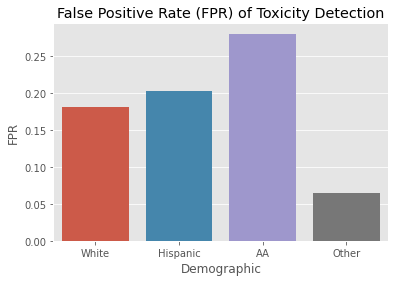

In [158]:
from sklearn.svm import LinearSVC

linSVC = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
#     ('svd', TruncatedSVD(algorithm='randomized', n_components=300)),
    ('linsvc', LinearSVC(random_state=0, tol=1e-5)),
])

model_eval(linSVC, "linSVC")

**Logistic Regression**

Accuracy: 75.23%
F1 Score: 0.835671
              precision    recall  f1-score   support

         0.0       0.76      0.37      0.50       440
         1.0       0.75      0.94      0.84       884

    accuracy                           0.75      1324
   macro avg       0.76      0.66      0.67      1324
weighted avg       0.75      0.75      0.72      1324

Accuracy dem: 88.98%
F1 Score dem: 0.941680

White FPR: 0.1050767414403778
Hispanic FPR: 0.12835820895522387
AA FPR: 0.21385542168674698
Other FPR: 0.0


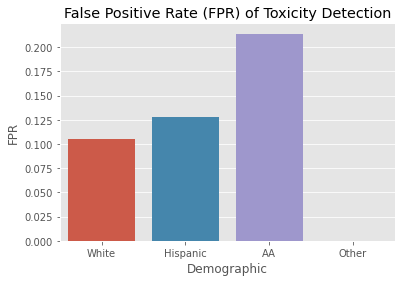

In [191]:
logr = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('logreg', LogisticRegression(penalty='l2')),
])

model_eval(logr, "lr")

In [199]:
test['processed'] = preprocessing(test.text.values)

100%|██████████| 6396/6396 [00:04<00:00, 1345.57it/s]


In [201]:
test['lr_pred'] = logr.predict(test.processed.values)

<AxesSubplot:xlabel='lr_pred', ylabel='count'>

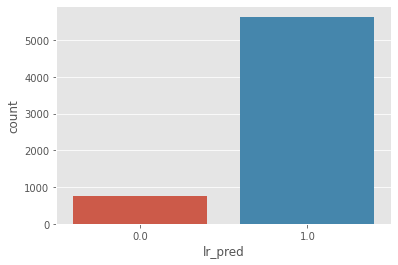

In [203]:
sns.countplot(test['lr_pred'])

In [233]:
mini_demographic_dev[mini_demographic_dev['demographic'] == 'AA'][mini_demographic_dev['pred_label'] != mini_demographic_dev['bin_label']]

text demographic  \
7                               gotta dawg ass headache          AA   
195   bet female police officer got ass pics faceboo...          AA   
293   naw nigga always want see body dials number nu...          AA   
446                        ima fresh hell feds watching          AA   
563              bro signal going nah shit straight cuh          AA   
...                                                 ...         ...   
4863                                       hell nah lol          AA   
4880                                 guh laid ass resum          AA   
4966                         sum weak ass number niggas          AA   
5020                                           punk ass          AA   
5063                                               shit          AA   

      perspective_score  bin_label  pred_label  pers_label  
7              0.760669          1           0           1  
195            0.837852          1           0           0  
293            0.950619          1           0           0  
446            0.665536          1           0           1  
563            0.837852          1           0           0  
...                 ...        ...         ...         ...  
4863           0.653658          1           0           1  
4880           0.956803          1           0           0  
4966           0.949175          1           0           0  
5020           0.965993          1           0           0  
5063           0.933319          1           0           0  

[71 rows x 6 columns]

In [244]:
logr.predict(['This is lit shit!'])

array([0.])

In [235]:
aa_tweets = mini_demographic_dev[mini_demographic_dev['demographic'] == 'AA'].text

In [246]:
train[train['label'] == 'OFF']['text']

1        seems hard believe stood next guy wearing shor...
2        wow wonder liberals got worse party bullies wo...
3                              not idiots grandstands like
4                          bring hypocrite gungrabber maga
6        thing agree match point following rules think ...
                               ...                        
10569                                      head fuckin egg
10575    advocating conduct within bounds human rights ...
10579            liars like antifa twins vigorously defend
10587    sometimes get strong vibes people man vibe ten...
10589                         report garbage not give crap
Name: text, Length: 3184, dtype: object

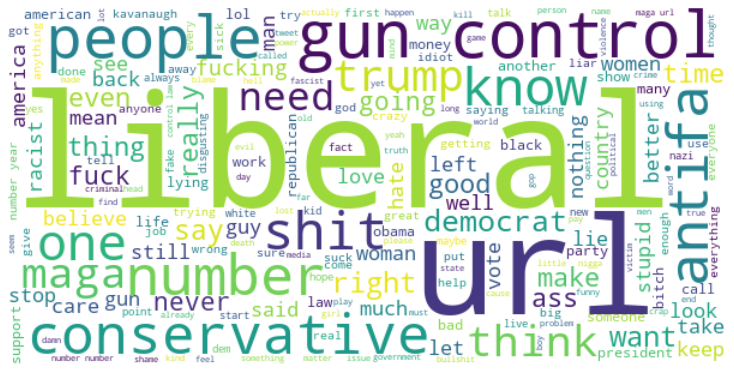

In [247]:
tweets = ' '.join(mini_demographic_dev[mini_demographic_dev['demographic'] == 'AA'].text)
wordcloud = WordCloud(
    width=600,
    height=300,
    background_color="white",
    stopwords=STOPWORDS.add("USER")).generate(tweets)
fig = plt.figure(
    figsize=(16,5),
    facecolor='w',
    edgecolor='w')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [206]:
test['lr_pred'] = [int(i) for i in test.lr_pred.values]
test

text  \
0     Black Female Democrats Call for Changes in Par...   
1     After making fun of myself (and @USER a little...   
2                         You know what I hate? Negros.   
3     :(( I want him to rest 4ever :((( He is such a...   
4     I wish I can blink my eyes and I'll magically ...   
...                                                 ...   
6391                            Celtics lose to Bobcats   
6392  Does anyone know if things got easier out ther...   
6393  Nothing like girl time with junk food, warm su...   
6394  @USER This is a guy who weaponized the judicia...   
6395  @USER said drinks on him \ud83d\udc40\ud83d\ud...   

                                              processed  lr_pred  
0     black female democrats call changes party url ...        1  
1     making fun little watching premier number time...        1  
2                                      know hate negros        0  
3            sad want rest ever sad sleepy baby sad url        1  
4                       wish blink eyes magically ready        1  
...                                                 ...      ...  
6391                               celtics lose bobcats        1  
6392                anyone know things got easier pimps        1  
6393  nothing like girl time junk food warm summer n...        1  
6394  guy weaponized judicial system irs attack cons...        1  
6395                                        said drinks        1  

[6396 rows x 3 columns]

In [213]:
test[test['lr_pred'] == 0].head(50)

text  \
2                        You know what I hate? Negros.   
24   @USER @USER @USER @USER LMAO! You are still bu...   
61   @USER @USER fuck you wanna be the next surfer ...   
73         damn straight #RapedByASlothAndItWasAmazing   
83   @USER Liberals support conflicting viewpoints ...   
84                                   So fucking sleepy   
86                                @USER lmao don't lie   
87   I may be the black sheep of the family,but som...   
103  She was just with another dude 2 days ago bro ...   
126  @USER you know it! Problem is getting the shit...   
128  They fuck wit my baby sis too much they just g...   
138                  Rugrats fuck with me \ud83d\ude01   
143  @USER I’m finna say fuck it and get a crispy a...   
152    are you a beaver cause damn.. #WorstPickUpLines   
168  Shanae is the most obnoxious one when drunk. #...   
186                        Trust a few, fuck the rest.   
187  It's amazing what two cups of coffee and shit ...   
199  @USER Yet more evidence that the @USER have tu...   
220                       Today is gonna suck #sotierd   
223                                     ohhhhh shut up   
225  Would anyone like to accompany me on some erra...   
240  @USER leaves again today. At least this time i...   
243  #Mueller #DOJ #FBI #CIA #LawEnforcement #Polic...   
247  I hate when my tanning package expires and the...   
251     I couldn't imagine being such a piece of shit.   
258                             Joel Anthony sucks lol   
267  @USER boy you sleeeeeeepppp 😭😭 ass be ret on P...   
270  @USER So we should believe this from 40 years ...   
274  I drive your car like an old lady cause I'm sc...   
277              Thee fact that, that shit want funny.   
290                             Like seriously lol wtf   
309  @USER Uhhh no.  Sadam gassed the shit out of t...   
316                People piss me off SO FUCKING MUCH.   
324                                      So damn tired   
325                                @USER U nasty bitch   
333                                   @USER A disgrace   
352     I can't believe my brother is 20. Shit is cray   
353             Stay the fuck out of my life. Bitches.   
358  Gettin caught, I'm definitely not about that l...   
369  @USER Yeah because godless liberals hate truth...   
370  @USER @USER @USER @USER @USER also trump IS a ...   
403                          I'm a bitch, I'm a lover.   
408                 Fuck I should if gone to the fair!   
422  i just want too sleep in for one day. thats al...   
425                                 I'm gonna throw up   
426  @USER This is so fake he’s unable to feel true...   
427  He better get his fucking act together because...   
429                     @USER Bono is clearly a racist   
446           @USER I can't even lie, you snacked him!   
448  @USER bitch please \u270b you know that you ca...   

                                             processed  lr_pred  
2                                     know hate negros        0  
24   lmao still butt hurt loser hitlary lost love s...        0  
61                     fuck wanna next surfer one hand        0  
73                   damn straight raped sloth amazing        0  
83   liberals support conflicting viewpoints score ...        0  
84                                      fucking sleepy        0  
86                                        lmao not lie        0  
87   may black sheep family white sheep not white t...        0  
103  another dude number days ago bro fucking make ...        0  
126  know problem getting shit ton together even ge...        0  
128           fuck wit baby sis much gave fuckin lemon        0  
138                                       rugrats fuck        0  
143         finna say fuck get crispy ass jogging suit        0  
152                 beaver cause damn worst pick lines        0  
168          shanae obnoxious one drunk shut bout turn        0  
186                                

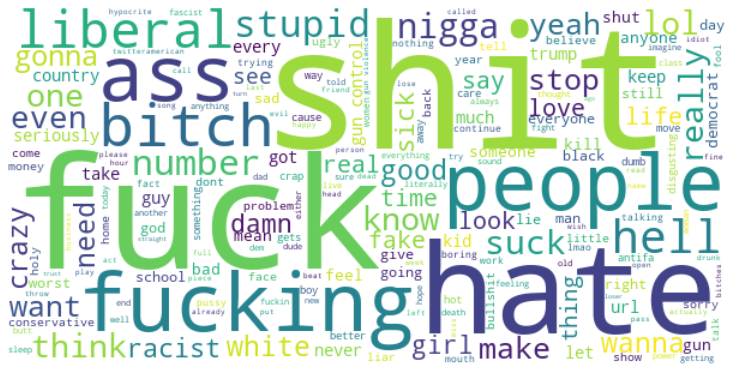

In [211]:
tweets = ' '.join(test[test['lr_pred'] == 0]['processed'].values)
wordcloud = WordCloud(
    width=600,
    height=300,
    background_color="white",
    stopwords=STOPWORDS.add("USER")).generate(tweets)
fig = plt.figure(
    figsize=(16,5),
    facecolor='w',
    edgecolor='w')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [220]:
test.index.values

array([   0,    1,    2, ..., 6393, 6394, 6395])

In [221]:
labels = pd.DataFrame()
labels['label'] = test['lr_pred']
labels

label
0         1
1         1
2         0
3         1
4         1
...     ...
6391      1
6392      1
6393      1
6394      1
6395      1

[6396 rows x 1 columns]

In [224]:
labels.to_csv(path_or_buf='Athiya_Deviyani_test.tsv', sep='\t', index=False)

Check where our model makes mistakes

In [175]:
def get_wordcloud(df):
    tweets = str(preprocessing(df[df.bin_label != df.pred_label].text.values))
    tweets = str(preprocessing([tweets]))
    wordcloud = WordCloud(
        width=600,
        height=300,
        background_color="white",
        stopwords=STOPWORDS.add("USER")).generate(tweets)
    fig = plt.figure(
        figsize=(16,5),
        facecolor='w',
        edgecolor='w')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()
    return tweets

100%|██████████| 1/1 [00:00<00:00, 16.80it/s]


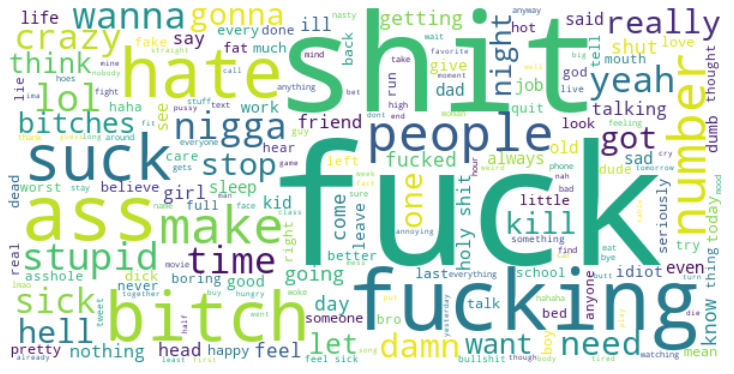

In [178]:
tweets1 = get_wordcloud(mini_demographic_dev)

In [82]:
mini_demographic_dev['pers_label'] = [0 if x > 0.8 else 1 for x in mini_demographic_dev['perspective_score']]

Training Logistic Regression model...
Accuracy: 75.68%
F1 Score: 0.838191
              precision    recall  f1-score   support

         0.0       0.77      0.38      0.51       440
         1.0       0.75      0.94      0.84       884

    accuracy                           0.76      1324
   macro avg       0.76      0.66      0.67      1324
weighted avg       0.76      0.76      0.73      1324

Accuracy dem: 90.14%
F1 Score dem: 0.948154

White FPR: 0.09327036599763873
Hispanic FPR: 0.11044776119402985
AA FPR: 0.20180722891566266
Other FPR: 0.0058823529411764705


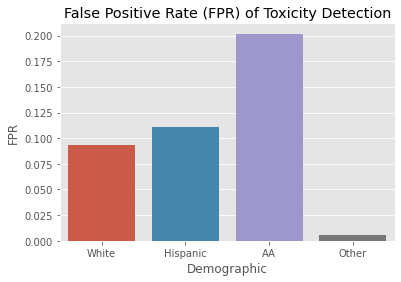

In [38]:
print("Training Logistic Regression model...")

model_eval(logr, "lr")

In [141]:
misclas = mini_demographic_dev[(mini_demographic_dev['pred_label'] != mini_demographic_dev['bin_label'])]
misclas[misclas['demographic'] == 'AA']

text demographic  \
243      gotta run errands work not finna let snow stop          AA   
563              bro signal going nah shit straight cuh          AA   
564                          update ight dumb sometimes          AA   
830                gnna pick gonna see befor get school          AA   
940               real niggas play tic tac toe self dfl          AA   
1008                            said stop stealing shit          AA   
1059                              thought fat hoes lien          AA   
1240                                      hang drug lol          AA   
1268  said gone hold grudge actually hate omf twiste...          AA   
1385  foreign car painted flat black girl hopped ass...          AA   
1586                       lemme find putting shit head          AA   
1594                 shit bitch talk facebook dfl crazy          AA   
1642                                         wanna text          AA   
1996                           girl stfu nobody talking          AA   
2270                                          back seat          AA   
2320                                         hows crazy          AA   
2513                                              crazy          AA   
2708                     sexually frustrated women lmao          AA   
2793                            fuck dumb ass site bruh          AA   
2841                                 girl dumb love tho          AA   
2956                    boy done held grudge like weeks          AA   
3416                                               dead          AA   
3541                                      janeesa wanna          AA   
3623                                    lls crazy right          AA   
3706                       hit mall wit bros later stro          AA   
3862                           war zone live shit crazy          AA   
3901                         lets get dis shit ovva wit          AA   
3930                     bro dese hoes fake fuckkkk god          AA   
4043  turn talkin nasty yuh gone eat dis ass nasty b...          AA   
4067                                            talking          AA   
4092                                        daily tweet          AA   
4282                          lol gotta like know meant          AA   
4441                                         app stupid          AA   
4498                                       really bitch          AA   
4529  hating niggas wanna see dead yall bitches wann...          AA   
4618                                      far wanna far          AA   
4662                           bitches lie bitches want          AA   
4689                                           get eyes          AA   
4714        alwaays saaay done yuuu buuut shxxxd nevaaa          AA   
4797     real shit bro acting like got whole period lol          AA   
4863                                       hell nah lol          AA   
4974            bye felicia lmao still not believe told          AA   

      perspective_score  bin_label  pred_label  pers_label  
243            0.102280          1           0           1  
563            0.837852          1           0           0  
564            0.717271          1           0           1  
830            0.378876          1           0           1  
940            0.767049          1           0           1  
1008           0.958430          1           0           0  
1059           0.319538          1           0           1  
1240           0.651947          1           0           1  
1268           0.435960          1           0           1  
1385           0.760987          1           0           1  
1586           0.932562          1           0           0  
1594           0.975682          1           0           0  
1642           0.215491          1           0           1  
1996           0.740122          1           0           1  
2270           0.224458          1           0           1  
2320           0.5508

**MultinomialNB**

Training Multinomial Naive Bayes model...
Accuracy: 72.05%
F1 Score: 0.823473
              precision    recall  f1-score   support

         0.0       0.81      0.21      0.33       440
         1.0       0.71      0.98      0.82       884

    accuracy                           0.72      1324
   macro avg       0.76      0.59      0.58      1324
weighted avg       0.75      0.72      0.66      1324

Accuracy dem: 92.84%
F1 Score dem: 0.962887

White FPR: 0.06493506493506493
Hispanic FPR: 0.07462686567164178
AA FPR: 0.1746987951807229
Other FPR: 0.029411764705882353


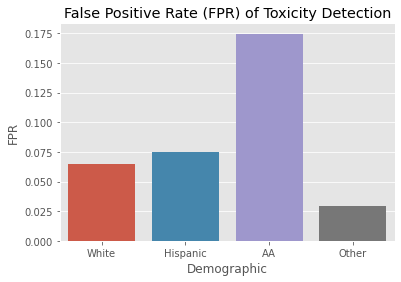

In [59]:
nb = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('nb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)),
])

print("Training Multinomial Naive Bayes model...")
model_eval(nb, "nb")

100%|██████████| 1/1 [00:00<00:00, 18.87it/s]


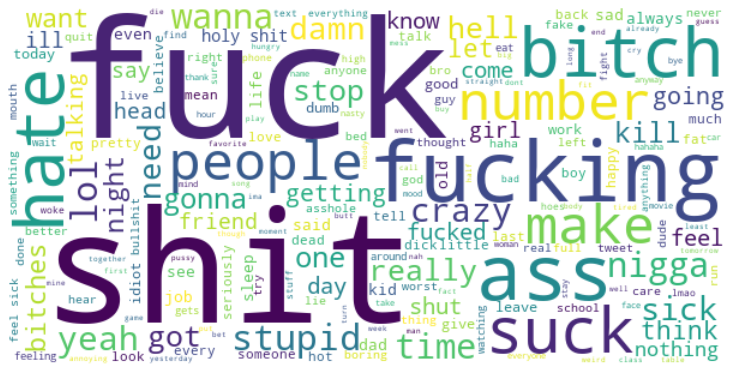

In [179]:
tweets2 = get_wordcloud(mini_demographic_dev)

100%|██████████| 1/1 [00:00<00:00,  6.33it/s]


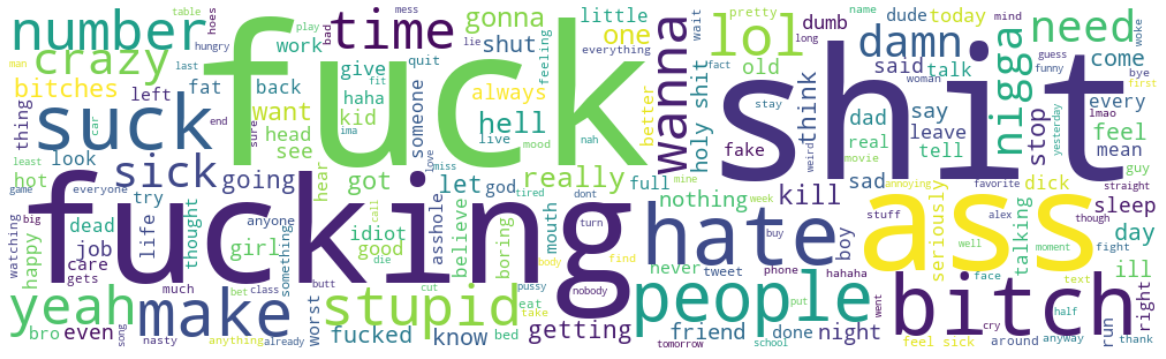

In [248]:
tweets = tweets1 + tweets2
tweets = str(preprocessing([tweets]))
wordcloud = WordCloud(
    width=1000,
    height=300,
    background_color="white",
    stopwords=STOPWORDS.add("USER")).generate(tweets)
fig = plt.figure(
    figsize=(16,5),
    facecolor='w',
    edgecolor='w')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

100%|██████████| 1/1 [00:00<00:00,  9.20it/s]


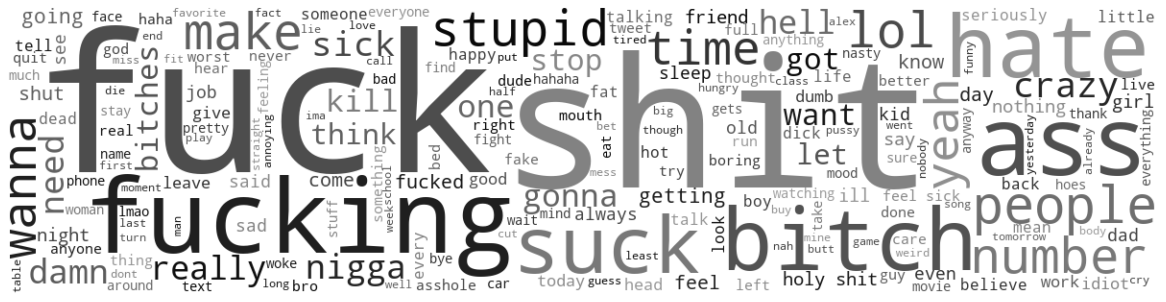

In [250]:
import random 

def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(0, 60)

tweets = tweets1 + tweets2
tweets = str(preprocessing([tweets]))
wordcloud = WordCloud(
    width=1200,
    height=300,
    color_func = grey_color_func,
    background_color = "white",
    stopwords=STOPWORDS.add("USER")).generate(tweets)
fig = plt.figure(
    figsize=(16,5),
    facecolor='w',
    edgecolor='w')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

**KNN**

In [89]:
logr.predict(['fuck'])

array([0.])

Training KNN model...
Accuracy: 69.49%
F1 Score: 0.792181
              precision    recall  f1-score   support

         0.0       0.57      0.34      0.43       440
         1.0       0.73      0.87      0.79       884

    accuracy                           0.69      1324
   macro avg       0.65      0.61      0.61      1324
weighted avg       0.67      0.69      0.67      1324

Accuracy dem: 76.72%
F1 Score dem: 0.868236

White FPR: 0.2049586776859504
Hispanic FPR: 0.2716417910447761
AA FPR: 0.3614457831325301
Other FPR: 0.6


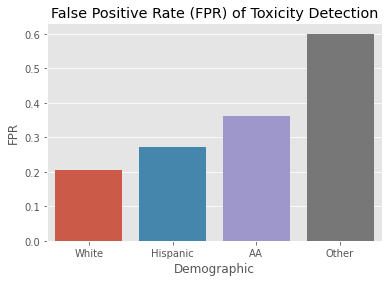

In [61]:
knn = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('knn', KNeighborsClassifier(n_neighbors=7, weights='uniform', 
                                 algorithm='brute', leaf_size=30, p=2, 
                                 metric='minkowski', metric_params=None)),
])

print("Training KNN model...")
model_eval(knn, "knn")

100%|██████████| 1/1 [00:00<00:00, 1535.81it/s]


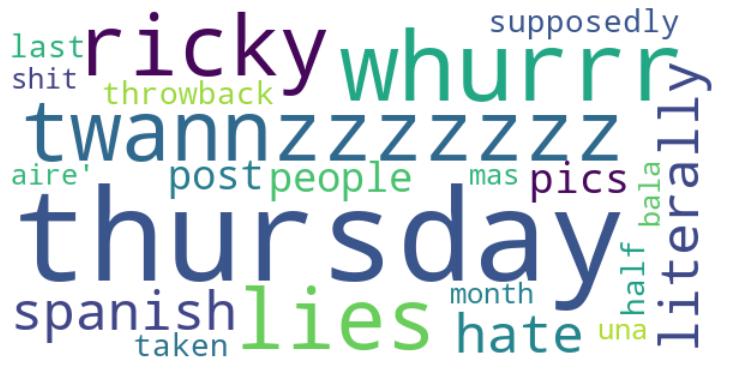

In [62]:
get_wordcloud(mini_demographic_dev)

**Random Forest**

Training Random Forest model...
Accuracy: 76.74%
F1 Score: 0.843655
              precision    recall  f1-score   support

         0.0       0.78      0.42      0.55       440
         1.0       0.77      0.94      0.84       884

    accuracy                           0.77      1324
   macro avg       0.77      0.68      0.69      1324
weighted avg       0.77      0.77      0.74      1324

Accuracy dem: 89.14%
F1 Score dem: 0.942562

White FPR: 0.10365997638724911
Hispanic FPR: 0.1253731343283582
AA FPR: 0.21084337349397592
Other FPR: 0.0


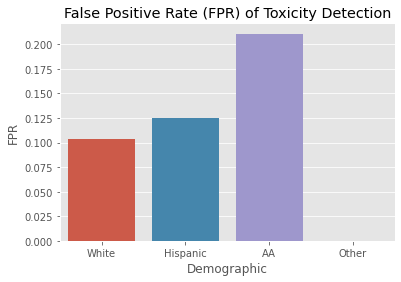

In [63]:
rf = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('rf', RandomForestClassifier()),
])

print("Training Random Forest model...")
model_eval(rf, "rf")

100%|██████████| 1/1 [00:00<00:00, 18.12it/s]


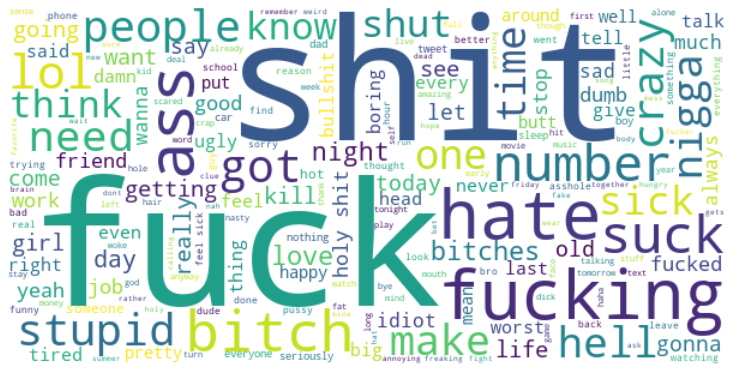

In [64]:
get_wordcloud(mini_demographic_dev)

**Decision Tree**

Training Decision Tree model...
Accuracy: 71.30%
F1 Score: 0.788183
              precision    recall  f1-score   support

         0.0       0.57      0.54      0.56       440
         1.0       0.78      0.80      0.79       884

    accuracy                           0.71      1324
   macro avg       0.67      0.67      0.67      1324
weighted avg       0.71      0.71      0.71      1324

Accuracy dem: 81.86%
F1 Score dem: 0.900260

White FPR: 0.1834710743801653
Hispanic FPR: 0.17313432835820897
AA FPR: 0.2319277108433735
Other FPR: 0.047058823529411764


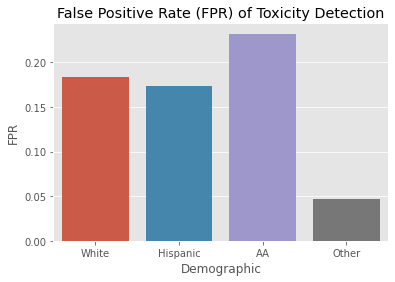

In [65]:
dt = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('dt', DecisionTreeClassifier()),
])

print("Training Decision Tree model...")
model_eval(dt, "dt")

100%|██████████| 1/1 [00:00<00:00, 10.29it/s]


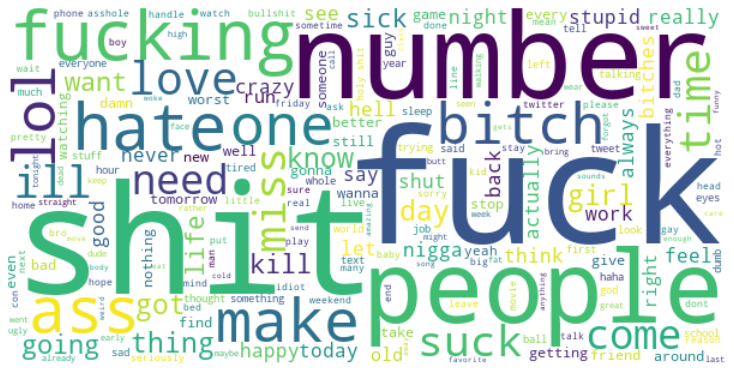

In [66]:
get_wordcloud(mini_demographic_dev)

### Model 2: TextCNN

In [56]:
import tensorflow as tf

# Tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

# CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Embedding, SpatialDropout1D, Dropout, MaxPool2D
from tensorflow.keras.layers import Conv2D, Reshape, Concatenate, Flatten
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.callbacks import Callback

# Visualization
from wordcloud import WordCloud, STOPWORDS

**Data preprocessing**

In [582]:
train.head(5)

text label category  bin_label
0      @USER @USER You are an embarrassing citizen!!   OFF      TIN          0
1  @USER Seems hard to believe that you stood nex...   OFF      TIN          0
2  @USER @USER @USER Wow !!! no wonder the Libera...   OFF      TIN          0
3  @USER @USER And not all idiots grandstands lik...   OFF      TIN          0
4      @USER Bring on the hypocrite gungrabber. MAGA   OFF      TIN          0

In [583]:
X_train, X_test

(array(['embarrassing citizen',
        'seems hard believe stood next guy wearing shorts masturbate take word',
        'wow wonder liberals got worse party bullies women accountability',
        ..., 'report garbage give crap', 'pussy',
        'spanishrevenge justice humanrights freedomofexpression spain fakedemocracy cddr shameonspain wakeupeurope url'],
       dtype='<U257'),
 array(['ask native americans take', 'home drunk maga trump url',
        'amazon investigating chinese employees selling internal data third party sellers looking edge competitive marketplace url amazon maga kag china tcot',
        ...,
        'not bizarre smart business gonna get paid someone next year saving body process yes connor well browns gameplan like would bell',
        'follow maga patriots got couple new ones tweeeeeetrrrr like hiding making hard see trains follw url',
        'sure hope removed hiding protecting chum water right'],
       dtype='<U237'))

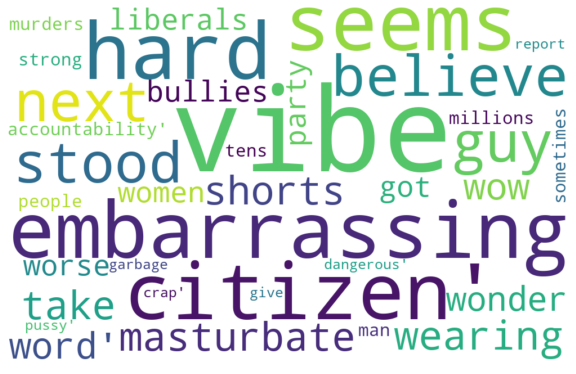

In [585]:
toxic_comments = preprocessing(train[train["bin_label"] == 0]["text"].values)
wordcloud = WordCloud(
    width=1000,
    height=640,
    background_color="white",
    stopwords=STOPWORDS.add("USER")).generate(str(toxic_comments))
fig = plt.figure(
    figsize=(16,5),
    facecolor='w',
    edgecolor='w')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

**Tokenize and generate word embeddings using GloVe**

In [586]:
max_features = 16097
max_text_length = 260
maxlen=max_text_length

In [587]:
tokenizer = Tokenizer(max_features)
tokenizer.fit_on_texts(X_train)

In [588]:
encoded_docs = tokenizer.texts_to_sequences(X_train)

In [589]:
x_train = pad_sequences(encoded_docs, maxlen=max_text_length)

In [590]:
x_test = tokenizer.texts_to_sequences(X_test)
x_test = pad_sequences(x_test, maxlen=max_text_length)

In [591]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

16098

In [592]:
# This cell takes ~30 seconds to run

embedding_dim = 100
embeddings_index = dict()

GLOVE_PATH = 'glove.twitter.27B.100d.txt'
with open(GLOVE_PATH, 'r') as glove_file:
    for line in tqdm(glove_file):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print("Found", len(embeddings_index), "word vectors!")

1193514it [00:26, 44948.17it/s]


Found 1193514 word vectors!


In [593]:
embedding_matrix = np.zeros((max_features, embedding_dim))
for word, index in tokenizer.word_index.items():
    if index > max_features-1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

**Build the model**

In [595]:
filter_sizes = [1,2,3,5]
num_filters = 32

def get_model():    
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embedding_dim, weights=[embedding_matrix])(inp)
    x = SpatialDropout1D(0.4)(x)
    x = Reshape((maxlen, embedding_dim, 1))(x)
    
    conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), kernel_initializer='normal',
                                                                                    activation='elu')(x)
    conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), kernel_initializer='normal',
                                                                                    activation='elu')(x)
    conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), kernel_initializer='normal',
                                                                                    activation='elu')(x)
    conv_3 = Conv2D(num_filters, kernel_size=(filter_sizes[3], embedding_dim), kernel_initializer='normal',
                                                                                    activation='elu')(x)
    
    maxpool_0 = MaxPool2D(pool_size=(maxlen - filter_sizes[0] + 1, 1))(conv_0)
    maxpool_1 = MaxPool2D(pool_size=(maxlen - filter_sizes[1] + 1, 1))(conv_1)
    maxpool_2 = MaxPool2D(pool_size=(maxlen - filter_sizes[2] + 1, 1))(conv_2)
    maxpool_3 = MaxPool2D(pool_size=(maxlen - filter_sizes[3] + 1, 1))(conv_3)
        
    z = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2, maxpool_3])   
    z = Flatten()(z)
    z = Dropout(0.3)(z)
        
    outp = Dense(1, activation="sigmoid")(z)
    
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
                  metrics=['accuracy'])

    return model

model = get_model()

tf.keras.utils.plot_model(
    model, to_file='textcnn_model.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None, show_layer_activations=False
)

batch_size = 1024
epochs = 20

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss vs. Epochs')
plt.legend()
plt.savefig('textcnn_loss.png')
plt.close()

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs. Epochs')
plt.legend()
plt.savefig('textcnn_accuracy.png')
plt.close()


y_pred = model.predict(x_test, verbose=1, batch_size=batch_size)
y_pred = [0 if y[0] < 0.5 else 1 for y in y_pred]

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("F1 Score: {:.6f}".format(f1_score(y_test, y_pred)))

cm = confusion_matrix(y_test, y_pred)
fig = sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.savefig("textcnn_cm.png")
plt.close()

model.save('textcnn.h5')

Epoch 1/20
10/10 [==============================] - 13s 1s/step - loss: 0.7104 - accuracy: 0.6277 - val_loss: 0.5852 - val_accuracy: 0.6953
Epoch 2/20
10/10 [==============================] - 12s 1s/step - loss: 0.6236 - accuracy: 0.6697 - val_loss: 0.5434 - val_accuracy: 0.7189
Epoch 3/20
10/10 [==============================] - 13s 1s/step - loss: 0.5856 - accuracy: 0.7065 - val_loss: 0.5191 - val_accuracy: 0.7415
Epoch 4/20
10/10 [==============================] - 14s 1s/step - loss: 0.5589 - accuracy: 0.7171 - val_loss: 0.4996 - val_accuracy: 0.7623
Epoch 5/20
10/10 [==============================] - 13s 1s/step - loss: 0.5324 - accuracy: 0.7371 - val_loss: 0.4868 - val_accuracy: 0.7745
Epoch 6/20
10/10 [==============================] - 13s 1s/step - loss: 0.5164 - accuracy: 0.7490 - val_loss: 0.4770 - val_accuracy: 0.7783
Epoch 7/20
10/10 [==============================] - 13s 1s/step - loss: 0.5060 - accuracy: 0.7538 - val_loss: 0.4692 - val_accuracy: 0.7783
Epoch 8/20
10/10 [==

In [596]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("F1 Score: {:.6f}".format(f1_score(y_test, y_pred)))

Accuracy: 78.32%
F1 Score: 0.843767


5/5 [==============================] - 1s 104ms/step
Accuracy dem: 85.96%
F1 Score dem: 0.924512
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.86      0.92      5072

    accuracy                           0.86      5072
   macro avg       0.50      0.43      0.46      5072
weighted avg       1.00      0.86      0.92      5072

White FPR: 0.13435655253837073
Hispanic FPR: 0.16119402985074627
AA FPR: 0.2680722891566265
Other FPR: 0.0


Text(0.5, 1.0, 'False Positive Rate (FPR) of Toxicity Detection')

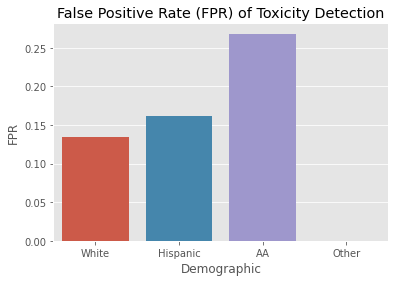

In [598]:
x_test_dev = tokenizer.texts_to_sequences(X_test_dev)
x_test_dev = pad_sequences(x_test_dev, maxlen=max_text_length)

# Test on demographic
y_pred_dev = model.predict(x_test_dev, verbose=1, batch_size=batch_size)
y_pred_dev = [0 if y[0] < 0.5 else 1 for y in y_pred_dev]


print("Accuracy dem: {:.2f}%".format(accuracy_score(y_test_dev, y_pred_dev) * 100))
print("F1 Score dem: {:.6f}".format(f1_score(y_test_dev, y_pred_dev)))
print(classification_report(y_test_dev, y_pred_dev))

mini_demographic_dev["pred_label"] = [int(i) for i in y_pred_dev]

white_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "White"]
hispanic_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "Hispanic"]
AA_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "AA"]
other_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "Other"]

white_fpr = get_fpr(white_df)
hispanic_fpr = get_fpr(hispanic_df)
AA_fpr = get_fpr(AA_df)
other_fpr = get_fpr(other_df)

print("White FPR:", white_fpr)
print("Hispanic FPR:", hispanic_fpr)
print("AA FPR:", AA_fpr)
print("Other FPR:", other_fpr)

ax = sns.barplot(['White', 'Hispanic', 'AA', 'Other'], [white_fpr, hispanic_fpr, AA_fpr, other_fpr])
ax.set_ylabel("FPR")
ax.set_xlabel("Demographic")
ax.set_title("False Positive Rate (FPR) of Toxicity Detection")

### Model 3: LSTM

In [599]:
import numpy as np
np.random.seed(42)
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
plt.style.use('ggplot')

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Embedding, SpatialDropout1D, concatenate, Dropout
from tensorflow.keras.layers import GRU, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.callbacks import Callback
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

#NLP tools
import re
import nltk
nltk.download('stopwords')
nltk.download('rslp')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

dev = pd.read_csv("civility_data/dev.tsv", sep='\t')
mini_demographic_dev = pd.read_csv("civility_data/mini_demographic_dev.tsv", sep='\t')
test = pd.read_csv("civility_data/test.tsv", sep='\t')
train = pd.read_csv("civility_data/train.tsv", sep='\t')

X_train = train["text"].values
y_train = np.array([0.0 if l=="OFF" else 1.0 for l in train["label"]])
X_test = dev["text"].values
y_test = np.array([0.0 if l=="OFF" else 1.0 for l in dev["label"]])

# Clean text
def preprocessing(data):
    all_stopwords = stopwords.words('english')
    all_stopwords.remove('not')
    corpus = []
    for tweet in data:
        review = re.sub(r"@[A-Za-z0-9_]+", " ", tweet)
        review = re.sub('RT', ' ', review)
        review = re.sub(r"https?://[A-Za-z0-9./]+", " ", review)
        review = re.sub(r"https?", " ", review)
        review = re.sub(r"\\[A-Za-z0-9./]+"," ", review)
        review = re.sub('[^a-zA-Z]', ' ', review)
        review = review.lower()
        review = review.split()
        review = [word for word in review if not word in set(all_stopwords) if len(word) > 2]
        review = ' '.join(review)
        corpus.append(review)

    return np.array(corpus)

print("Preprocessing tweets...")
X_train = preprocessing(X_train)
X_test = preprocessing(X_test)


max_features = 16097
maxlen = 260
embedding_dim = 100

tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)


embeddings_index = dict()

GLOVE_PATH = 'glove.twitter.27B.100d.txt'
print("Processing GloVe word embeddings...")
with open(GLOVE_PATH, 'r') as glove_file:
    for line in glove_file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print("Found", len(embeddings_index), "word vectors!")

embedding_matrix = np.zeros((max_features, embedding_dim))
print("Creating embedding matrix...")
for i in tqdm(range(len(tokenizer.word_index.items()))):
    word, index = list(tokenizer.word_index.items())[i]
    if index > max_features-1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

def get_model():
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embedding_dim, weights=[embedding_matrix])(inp)
    x = SpatialDropout1D(0.3)(x)
    x = Bidirectional(GRU(80, return_sequences=True))(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    x = Dense(128, activation='relu')(conc)
    x = Dropout(0.5)(x)   
    outp = Dense(1, activation="sigmoid")(x)
    
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

model = get_model()
tf.keras.utils.plot_model(
    model, to_file='lstm_model.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None, show_layer_activations=False
)


batch_size = 1024
epochs = 10

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss vs. Epochs')
plt.legend()
plt.savefig('lstm_loss.png')
plt.close()

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs. Epochs')
plt.legend()
plt.savefig('lstm_accuracy.png')
plt.close()


y_pred = model.predict(X_test, verbose=1, batch_size=batch_size)
y_pred = [0 if y[0] < 0.5 else 1 for y in y_pred]

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("F1 Score: {:.6f}".format(f1_score(y_test, y_pred)))

cm = confusion_matrix(y_test, y_pred)
fig = sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.savefig("lstm_cm.png")
plt.close()

model.save('lstm.h5')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/athiyadeviyani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     /Users/athiyadeviyani/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


Preprocessing tweets...
Processing GloVe word embeddings...


  0%|          | 80/16097 [00:00<00:20, 798.25it/s]

Found 1193514 word vectors!
Creating embedding matrix...


100%|█████████▉| 16096/16097 [00:17<00:00, 906.16it/s]


Epoch 1/10
10/10 [==============================] - 25s 2s/step - loss: 0.6614 - accuracy: 0.6476 - val_loss: 0.6345 - val_accuracy: 0.6575
Epoch 2/10
10/10 [==============================] - 25s 3s/step - loss: 0.6193 - accuracy: 0.6709 - val_loss: 0.5940 - val_accuracy: 0.6613
Epoch 3/10
10/10 [==============================] - 26s 3s/step - loss: 0.5758 - accuracy: 0.7000 - val_loss: 0.5485 - val_accuracy: 0.7009
Epoch 4/10
10/10 [==============================] - 22s 2s/step - loss: 0.5317 - accuracy: 0.7300 - val_loss: 0.5071 - val_accuracy: 0.7547
Epoch 5/10
10/10 [==============================] - 24s 2s/step - loss: 0.4976 - accuracy: 0.7550 - val_loss: 0.4811 - val_accuracy: 0.7726
Epoch 6/10
10/10 [==============================] - 22s 2s/step - loss: 0.4772 - accuracy: 0.7770 - val_loss: 0.4631 - val_accuracy: 0.7840
Epoch 7/10
10/10 [==============================] - 25s 3s/step - loss: 0.4509 - accuracy: 0.7871 - val_loss: 0.4524 - val_accuracy: 0.7877
Epoch 8/10
10/10 [==

5/5 [==============================] - 4s 765ms/step
Accuracy dem: 86.12%
F1 Score dem: 0.925424
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.86      0.93      5072

    accuracy                           0.86      5072
   macro avg       0.50      0.43      0.46      5072
weighted avg       1.00      0.86      0.93      5072

White FPR: 0.13246753246753246
Hispanic FPR: 0.16417910447761194
AA FPR: 0.26506024096385544
Other FPR: 0.0


Text(0.5, 1.0, 'False Positive Rate (FPR) of Toxicity Detection')

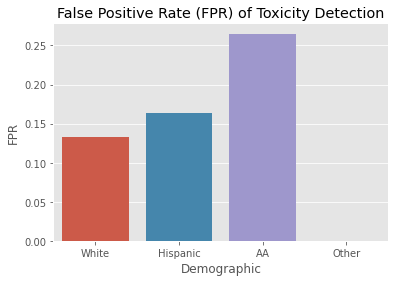

In [600]:
x_test_dev = tokenizer.texts_to_sequences(X_test_dev)
x_test_dev = pad_sequences(x_test_dev, maxlen=max_text_length)

# Test on demographic
y_pred_dev = model.predict(x_test_dev, verbose=1, batch_size=batch_size)
y_pred_dev = [0 if y[0] < 0.5 else 1 for y in y_pred_dev]


print("Accuracy dem: {:.2f}%".format(accuracy_score(y_test_dev, y_pred_dev) * 100))
print("F1 Score dem: {:.6f}".format(f1_score(y_test_dev, y_pred_dev)))
print(classification_report(y_test_dev, y_pred_dev))

mini_demographic_dev["pred_label"] = [int(i) for i in y_pred_dev]
mini_demographic_dev["bin_label"] = [1 for _ in range(len(mini_demographic_dev))]

white_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "White"]
hispanic_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "Hispanic"]
AA_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "AA"]
other_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "Other"]

white_fpr = get_fpr(white_df)
hispanic_fpr = get_fpr(hispanic_df)
AA_fpr = get_fpr(AA_df)
other_fpr = get_fpr(other_df)

print("White FPR:", white_fpr)
print("Hispanic FPR:", hispanic_fpr)
print("AA FPR:", AA_fpr)
print("Other FPR:", other_fpr)

ax = sns.barplot(['White', 'Hispanic', 'AA', 'Other'], [white_fpr, hispanic_fpr, AA_fpr, other_fpr])
ax.set_ylabel("FPR")
ax.set_xlabel("Demographic")
ax.set_title("False Positive Rate (FPR) of Toxicity Detection")

### Model 4: RNN

In [601]:
import numpy as np
np.random.seed(42)
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
plt.style.use('ggplot')

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Input, Dense, Embedding, SpatialDropout1D, concatenate, Dropout
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.callbacks import Callback
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

#NLP tools
import re
import nltk
nltk.download('stopwords')
nltk.download('rslp')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

dev = pd.read_csv("civility_data/dev.tsv", sep='\t')
mini_demographic_dev = pd.read_csv("civility_data/mini_demographic_dev.tsv", sep='\t')
test = pd.read_csv("civility_data/test.tsv", sep='\t')
train = pd.read_csv("civility_data/train.tsv", sep='\t')

X_train = train["text"].values
y_train = np.array([0.0 if l=="OFF" else 1.0 for l in train["label"]])
X_test = dev["text"].values
y_test = np.array([0.0 if l=="OFF" else 1.0 for l in dev["label"]])

# Clean text
def preprocessing(data):
    all_stopwords = stopwords.words('english')
    all_stopwords.remove('not')
    corpus = []
    for tweet in data:
        review = re.sub(r"@[A-Za-z0-9_]+", " ", tweet)
        review = re.sub('RT', ' ', review)
        review = re.sub(r"https?://[A-Za-z0-9./]+", " ", review)
        review = re.sub(r"https?", " ", review)
        review = re.sub(r"\\[A-Za-z0-9./]+"," ", review)
        review = re.sub('[^a-zA-Z]', ' ', review)
        review = review.lower()
        review = review.split()
        review = [word for word in review if not word in set(all_stopwords) if len(word) > 2]
        review = ' '.join(review)
        corpus.append(review)

    return np.array(corpus)

print("Preprocessing tweets...")
X_train = preprocessing(X_train)
X_test = preprocessing(X_test)


max_features = 16097
maxlen = 260
embedding_dim = 100

tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)


embeddings_index = dict()

GLOVE_PATH = 'glove.twitter.27B.100d.txt'
print("Processing GloVe word embeddings...")
with open(GLOVE_PATH, 'r') as glove_file:
    for line in glove_file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print("Found", len(embeddings_index), "word vectors!")

embedding_matrix = np.zeros((max_features, embedding_dim))
print("Creating embedding matrix...")
for i in tqdm(range(len(tokenizer.word_index.items()))):
    word, index = list(tokenizer.word_index.items())[i]
    if index > max_features-1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

def get_model():
    inputs = Input(name='inputs',shape=[maxlen])
    layer = Embedding(max_features, embedding_dim, weights=[embedding_matrix])(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    model.compile(loss='binary_crossentropy',
                  optimizer=RMSprop(),
                  metrics=['accuracy'])

    return model

model = get_model()
tf.keras.utils.plot_model(
    model, to_file='rnn_model.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None, show_layer_activations=False
)


batch_size = 1024
epochs = 10

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss vs. Epochs')
plt.legend()
plt.savefig('rnn_loss.png')
plt.close()

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs. Epochs')
plt.legend()
plt.savefig('rnn_accuracy.png')
plt.close()


y_pred = model.predict(X_test, verbose=1, batch_size=batch_size)
y_pred = [0 if y[0] < 0.5 else 1 for y in y_pred]

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("F1 Score: {:.6f}".format(f1_score(y_test, y_pred)))

cm = confusion_matrix(y_test, y_pred)
fig = sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.savefig("rnn_cm.png")
plt.close()

model.save('rnn.h5')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/athiyadeviyani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     /Users/athiyadeviyani/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


Preprocessing tweets...
Processing GloVe word embeddings...


  1%|          | 99/16097 [00:00<00:16, 988.65it/s]

Found 1193514 word vectors!
Creating embedding matrix...


100%|█████████▉| 16096/16097 [00:20<00:00, 776.65it/s]


Epoch 1/10
10/10 [==============================] - 13s 1s/step - loss: 0.6329 - accuracy: 0.6482 - val_loss: 0.5712 - val_accuracy: 0.7019
Epoch 2/10
10/10 [==============================] - 11s 1s/step - loss: 0.5485 - accuracy: 0.7214 - val_loss: 0.5480 - val_accuracy: 0.7189
Epoch 3/10
10/10 [==============================] - 12s 1s/step - loss: 0.5022 - accuracy: 0.7576 - val_loss: 0.5011 - val_accuracy: 0.7538
Epoch 4/10
10/10 [==============================] - 11s 1s/step - loss: 0.4715 - accuracy: 0.7782 - val_loss: 0.4827 - val_accuracy: 0.7585
Epoch 5/10
10/10 [==============================] - 11s 1s/step - loss: 0.4525 - accuracy: 0.7949 - val_loss: 0.4783 - val_accuracy: 0.7689
Epoch 6/10
10/10 [==============================] - 11s 1s/step - loss: 0.4145 - accuracy: 0.8171 - val_loss: 0.5273 - val_accuracy: 0.7679
Epoch 7/10
10/10 [==============================] - 11s 1s/step - loss: 0.4127 - accuracy: 0.8172 - val_loss: 0.4835 - val_accuracy: 0.7632
Epoch 8/10
10/10 [==

5/5 [==============================] - 3s 515ms/step
Accuracy dem: 87.46%
F1 Score dem: 0.933109
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.87      0.93      5072

    accuracy                           0.87      5072
   macro avg       0.50      0.44      0.47      5072
weighted avg       1.00      0.87      0.93      5072

White FPR: 0.11971664698937426
Hispanic FPR: 0.13432835820895522
AA FPR: 0.25301204819277107
Other FPR: 0.0


Text(0.5, 1.0, 'False Positive Rate (FPR) of Toxicity Detection')

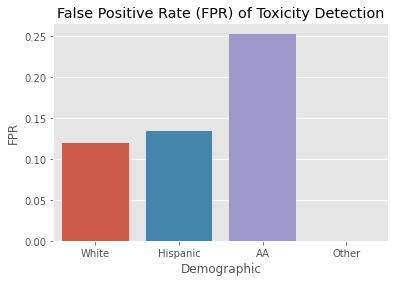

In [602]:
x_test_dev = tokenizer.texts_to_sequences(X_test_dev)
x_test_dev = pad_sequences(x_test_dev, maxlen=max_text_length)

# Test on demographic
y_pred_dev = model.predict(x_test_dev, verbose=1, batch_size=batch_size)
y_pred_dev = [0 if y[0] < 0.5 else 1 for y in y_pred_dev]


print("Accuracy dem: {:.2f}%".format(accuracy_score(y_test_dev, y_pred_dev) * 100))
print("F1 Score dem: {:.6f}".format(f1_score(y_test_dev, y_pred_dev)))
print(classification_report(y_test_dev, y_pred_dev))

mini_demographic_dev["pred_label"] = [int(i) for i in y_pred_dev]
mini_demographic_dev["bin_label"] = [1 for _ in range(len(mini_demographic_dev))]

white_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "White"]
hispanic_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "Hispanic"]
AA_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "AA"]
other_df = mini_demographic_dev[mini_demographic_dev["demographic"] == "Other"]

white_fpr = get_fpr(white_df)
hispanic_fpr = get_fpr(hispanic_df)
AA_fpr = get_fpr(AA_df)
other_fpr = get_fpr(other_df)

print("White FPR:", white_fpr)
print("Hispanic FPR:", hispanic_fpr)
print("AA FPR:", AA_fpr)
print("Other FPR:", other_fpr)

ax = sns.barplot(['White', 'Hispanic', 'AA', 'Other'], [white_fpr, hispanic_fpr, AA_fpr, other_fpr])
ax.set_ylabel("FPR")
ax.set_xlabel("Demographic")
ax.set_title("False Positive Rate (FPR) of Toxicity Detection")

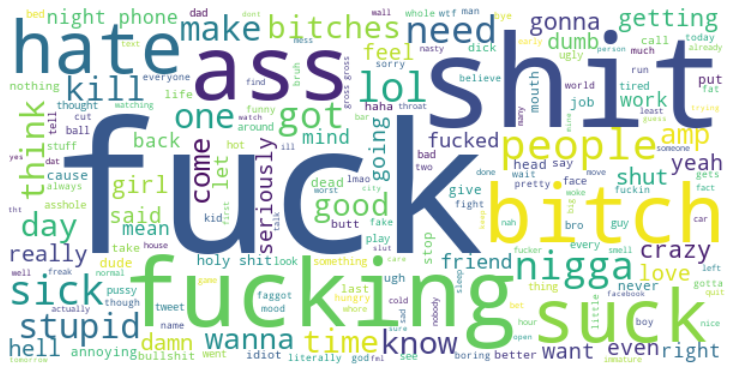

In [603]:
get_wordcloud(mini_demographic_dev)